## example

In [6]:
import cv2
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import os
import ast

In [7]:
map_image = cv2.imread(r"ref_image\map\book_fair_2019.jpg")
cam_image = cv2.imread(r"ref_image\cam\roi\front_room_roi.png")

In [8]:
with open("H_cam2map.json", "r") as f:
    transform = json.load(f)

H = np.array(transform["match_front_room"])
H

array([[ 0.95499152,  1.44536406,  0.05376705],
       [-0.02739988,  1.65504677,  0.10712096],
       [-0.07299328,  2.60997656,  1.        ]])

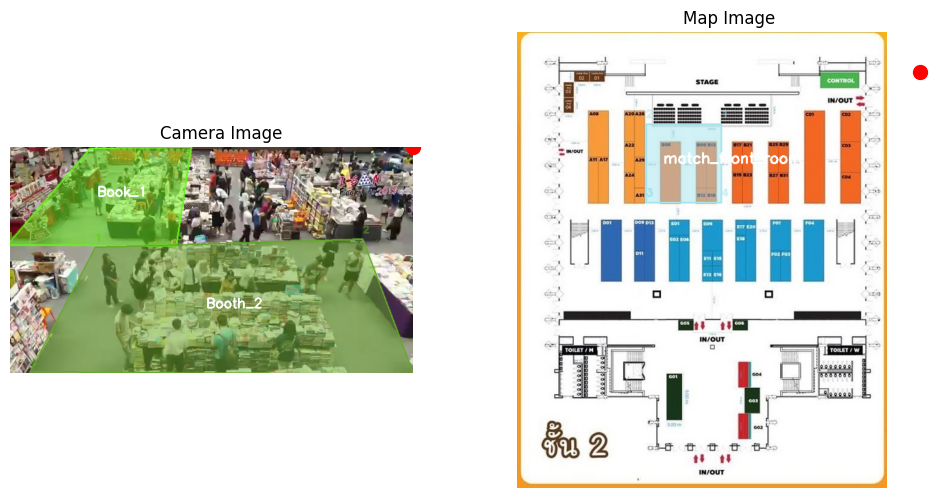

In [4]:
example_point = np.array([1,0, 1])
output_point = H @ example_point
tranformed_point = output_point[:2] / output_point[2]
tranformed_point

# plot map and cam
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(cam_image, cv2.COLOR_BGR2RGB))
plt.scatter(example_point[0] * cam_image.shape[1], example_point[1] * cam_image.shape[0], color='red', s=100, label='Example Point')
plt.title("Camera Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(map_image, cv2.COLOR_BGR2RGB))
plt.scatter(tranformed_point[0] * map_image.shape[1], tranformed_point[1] * map_image.shape[0], color='red', s=100, label='Transformed Point')
plt.title("Map Image")
plt.axis("off")


plt.show()


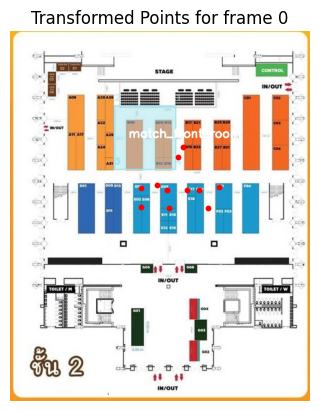

In [5]:
# โหลด CSV detections
df = pd.read_csv(r"detections_log.csv")

# เลือก frame_id ที่ต้องการ
frame_id = 0
frame_df = df[df["frame_id"] == frame_id]

# เตรียม list สำหรับเก็บจุดที่แปลงแล้ว
transformed_points = []

for i, row in frame_df.iterrows():
    xy_str = row["person_xy"]  # เช่น "[0.4189, 0.8903]"
    try:
        xy = eval(xy_str)  # แปลง string → list [x, y]
    except:
        continue  # ถ้า format ไม่ถูกข้าม

    # สร้างจุดในรูปแบบ homogeneous (x, y, 1)
    example_point = np.array([xy[0], xy[1], 1])

    # คูณกับ H matrix
    output_point = H @ example_point

    # Normalize กลับมาเป็น (x, y)
    transformed_point = output_point[:2] / output_point[2]
    transformed_points.append(transformed_point)

# Plot จุดทั้งหมดบน map
plt.imshow(cv2.cvtColor(map_image, cv2.COLOR_BGR2RGB))

map_h, map_w = map_image.shape[:2]
for pt in transformed_points:
    plt.scatter(pt[0] * map_w, pt[1] * map_h, color='red', s=10)

plt.title(f"Transformed Points for frame {frame_id}")
plt.axis("off")
plt.show()

## Test

Map image size: width=540, height=666
Error: VideoWriter failed to initialize!
Total frames: 9575


Processing frames:   0%|          | 18/9575 [00:03<32:14,  4.94it/s]


KeyboardInterrupt: 

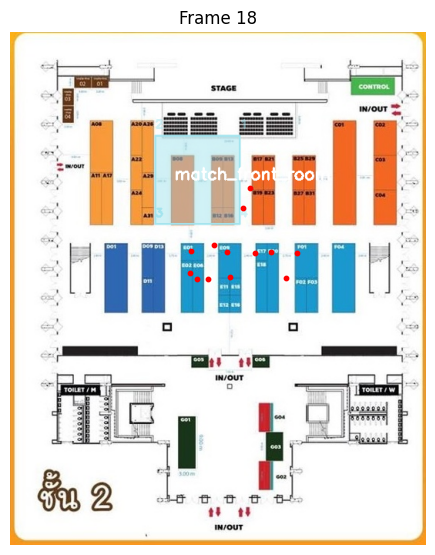

: 

In [ ]:
# โหลด CSV detections
df = pd.read_csv(r"detections_log.csv")

# กำหนดขนาดวิดีโอจากขนาด map
map_h, map_w = map_image.shape[:2]
map_w -= (map_w % 2)
map_h -= (map_h % 2)
print(f"Map image size: width={map_w}, height={map_h}")

# สร้าง VideoWriter
output_path = "output_detections_video.mp4"
fourcc = cv2.VideoWriter_fourcc(*'H264')  # ถ้า H264 ไม่ได้ ลอง XVID
out = cv2.VideoWriter(output_path, fourcc, fps=30.0, frameSize=(map_w, map_h))


if not out.isOpened():
    print("Error: VideoWriter failed to initialize!")
    exit()

frame_ids = sorted(df["frame_id"].unique())
print(f"Total frames: {len(frame_ids)}")

# วนลูปพร้อม progress bar
for frame_id in tqdm(frame_ids, desc="Processing frames"):
    frame_df = df[df["frame_id"] == frame_id]
    transformed_points = []

    for i, row in frame_df.iterrows():
        xy_str = row["person_xy"]
        try:
            xy = eval(xy_str)
        except Exception as e:
            print(f"Error parsing person_xy in frame {frame_id}, row {i}: {xy_str}, {e}")
            continue

        example_point = np.array([xy[0], xy[1], 1])
        output_point = H @ example_point
        transformed_point = output_point[:2] / output_point[2]
        transformed_points.append(transformed_point)

    fig = plt.figure(figsize=(map_w / 100, map_h / 100), dpi=100)
    canvas = FigureCanvas(fig)
    ax = fig.add_subplot(111)

    ax.imshow(cv2.cvtColor(map_image, cv2.COLOR_BGR2RGB))
    for pt in transformed_points:
        ax.scatter(pt[0] * map_w, pt[1] * map_h, color='red', s=10)

    ax.set_title(f"Frame {frame_id}")
    ax.axis("off")

    canvas.draw()
    frame = np.asarray(canvas.renderer.buffer_rgba())[:, :, :3]
    frame = frame[:, :, ::-1]  # RGB → BGR

    if frame.shape[:2] != (map_h, map_w):
        frame = cv2.resize(frame, (map_w, map_h), interpolation=cv2.INTER_AREA)

    out.write(frame)
    plt.close(fig)

out.release()

if os.path.exists(output_path):
    print(f"✅ Video saved to {output_path}, size: {os.path.getsize(output_path)} bytes")
else:
    print("❌ Error: Output video file was not created!")

## fill_missing

In [9]:
# --- 1. Load Data and Setup ---
# Load CSV detections
df = pd.read_csv(r"detections_log_front_room_2.csv")

# Convert the string representations of lists to actual lists
# 'ast.literal_eval' is a safe way to evaluate a string containing a Python literal
df['person_box'] = df['person_box'].apply(ast.literal_eval)
df['person_xy'] = df['person_xy'].apply(ast.literal_eval)

# Assumed variables (replace with your actual data)
# H is the homography matrix
# map_image is the background image for the video
# H = np.array([[...], [...], [...]])
# map_image = cv2.imread('path_to_your_map_image.png')

# Set video dimensions based on map image size
map_h, map_w = map_image.shape[:2]
map_w -= (map_w % 2)
map_h -= (map_h % 2)
print(f"Map image size: width={map_w}, height={map_h}")

# --- 2. VideoWriter Setup ---
output_path = "output_detections_video.mp4"
# 'H264' is a modern codec. If it doesn't work, 'XVID' is a common alternative.
fourcc = cv2.VideoWriter_fourcc(*'H264')
out = cv2.VideoWriter(output_path, fourcc, fps=30.0, frameSize=(map_w, map_h))

if not out.isOpened():
    print("Error: VideoWriter failed to initialize! Check codec or file path.")
    exit()

frame_ids = sorted(df["frame_id"].unique())
print(f"Total frames: {len(frame_ids)}")

# --- 3. Processing Loop ---
# Loop with progress bar
for frame_id in tqdm(frame_ids, desc="Processing frames"):
    frame_df = df[df["frame_id"] == frame_id]
    transformed_points = []
    
    for _, row in frame_df.iterrows():
        # The 'person_xy' column is already a list due to 'ast.literal_eval' above.
        # Use the data directly, no need for eval().
        xy = row["person_xy"]
        
        # Validate data before processing
        if isinstance(xy, (list, tuple)) and len(xy) == 2:
            example_point = np.array([xy[0], xy[1], 1])
            output_point = H @ example_point
            transformed_point = output_point[:2] / output_point[2]
            transformed_points.append(transformed_point)
        else:
            print(f"Warning: Invalid xy data for frame {frame_id}: {xy}")
            continue

    # --- 4. Plotting and Video Writing ---
    # Create a figure for plotting
    fig = plt.figure(figsize=(map_w / 100, map_h / 100), dpi=100)
    canvas = FigureCanvas(fig)
    ax = fig.add_subplot(111)

    # Plot the map and transformed points
    ax.imshow(cv2.cvtColor(map_image, cv2.COLOR_BGR2RGB))
    for pt in transformed_points:
        ax.scatter(pt[0] * map_w, pt[1] * map_h, color='red', s=10)

    ax.set_title(f"Frame {frame_id}")
    ax.axis("off")

    # Render the plot to a frame
    canvas.draw()
    frame = np.asarray(canvas.renderer.buffer_rgba())[:, :, :3]
    frame = frame[:, :, ::-1]  # RGB → BGR

    if frame.shape[:2] != (map_h, map_w):
        frame = cv2.resize(frame, (map_w, map_h), interpolation=cv2.INTER_AREA)

    out.write(frame)
    plt.close(fig)

# --- 5. Finalization ---
out.release()

if os.path.exists(output_path):
    print(f"✅ Video saved to {output_path}, size: {os.path.getsize(output_path)} bytes")
else:
    print("❌ Error: Output video file was not created!")

Map image size: width=540, height=666
Total frames: 19363


Processing frames: 100%|██████████| 19363/19363 [18:51<00:00, 17.11it/s]  


✅ Video saved to output_detections_video.mp4, size: 59571557 bytes
